In [80]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-07 15:05:12,398 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [ ]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')

In [6]:
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2019', '2020', '2021', '2022']).filter_within_geometry(sierras)

In [3]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-07 11:45:51,353 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:45:51,658 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:45:52,781 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:45:53,123 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:45:53,285 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [4]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-07 11:48:33,031 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:48:33,549 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:48:35,883 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:48:36,709 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:48:37,025 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

## Aggregate analysis of GEDI measurements across all fires from 2019-2022

In [34]:
firep = sierra_firep.perimeters.dropna(subset=['ALARM_DATE', 'CONT_DATE', 'FIRE_NAME'])
firep = firep[firep.FIRE_NAME != 'W-4 TERMO']
firep = firep[firep.FIRE_NAME != 'BEALE2']

In [48]:
matches = gedi_matching.match_across_fire_perimeters(firep, gedi_burned, 'agbd')

Skipped fire NELSON. No matching GEDI shots found.
Skipped fire ATHENS. No matching GEDI shots found.
Skipped fire FLEMING. No matching GEDI shots found.
Skipped fire MELANESE. No matching GEDI shots found.
Skipped fire VALLEY. No matching GEDI shots found.
Skipped fire WALDO. No matching GEDI shots found.
Skipped fire WILLOW. No matching GEDI shots found.
Skipped fire FIELDS. No matching GEDI shots found.
Skipped fire PAVE PAWS. No matching GEDI shots found.
Skipped fire RIOSA. No matching GEDI shots found.
Skipped fire NELSON. No matching GEDI shots found.
Skipped fire TEDDY. No matching GEDI shots found.
Skipped fire AVOCADO. No matching GEDI shots found.
Skipped fire HONCUT. No matching GEDI shots found.
Skipped fire GRAND. No matching GEDI shots found.
Skipped fire CLARK. No matching GEDI shots found.
Skipped fire KARCHNER. No matching GEDI shots found.
Skipped fire GARDEN. No matching GEDI shots found.
Skipped fire FEATHER. No matching GEDI shots found.
Skipped fire FLAT. No matc

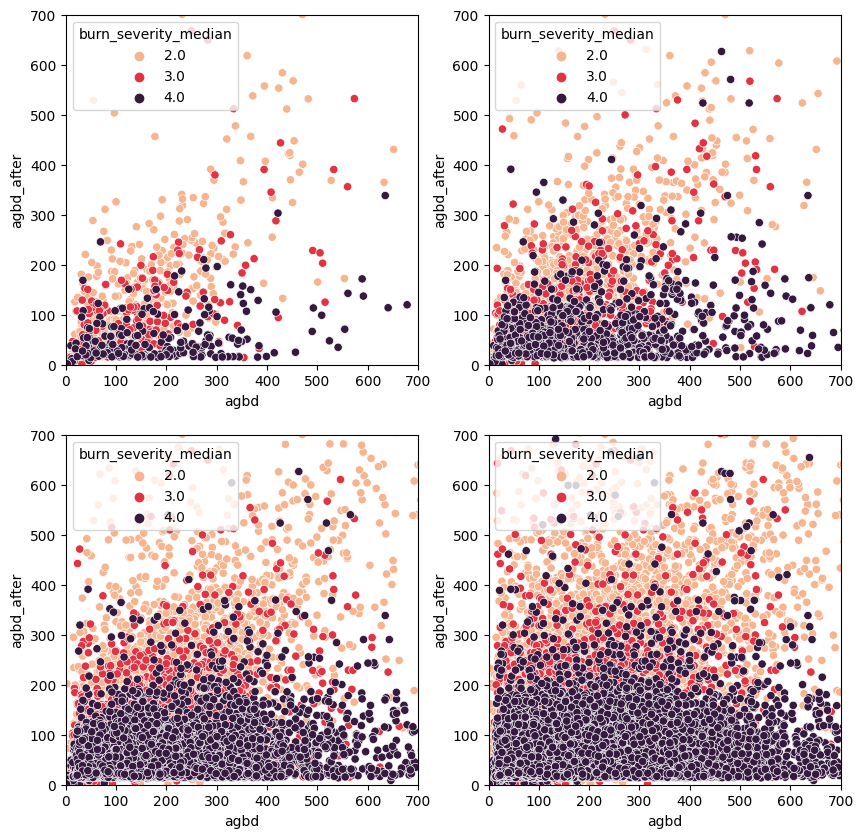

In [49]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

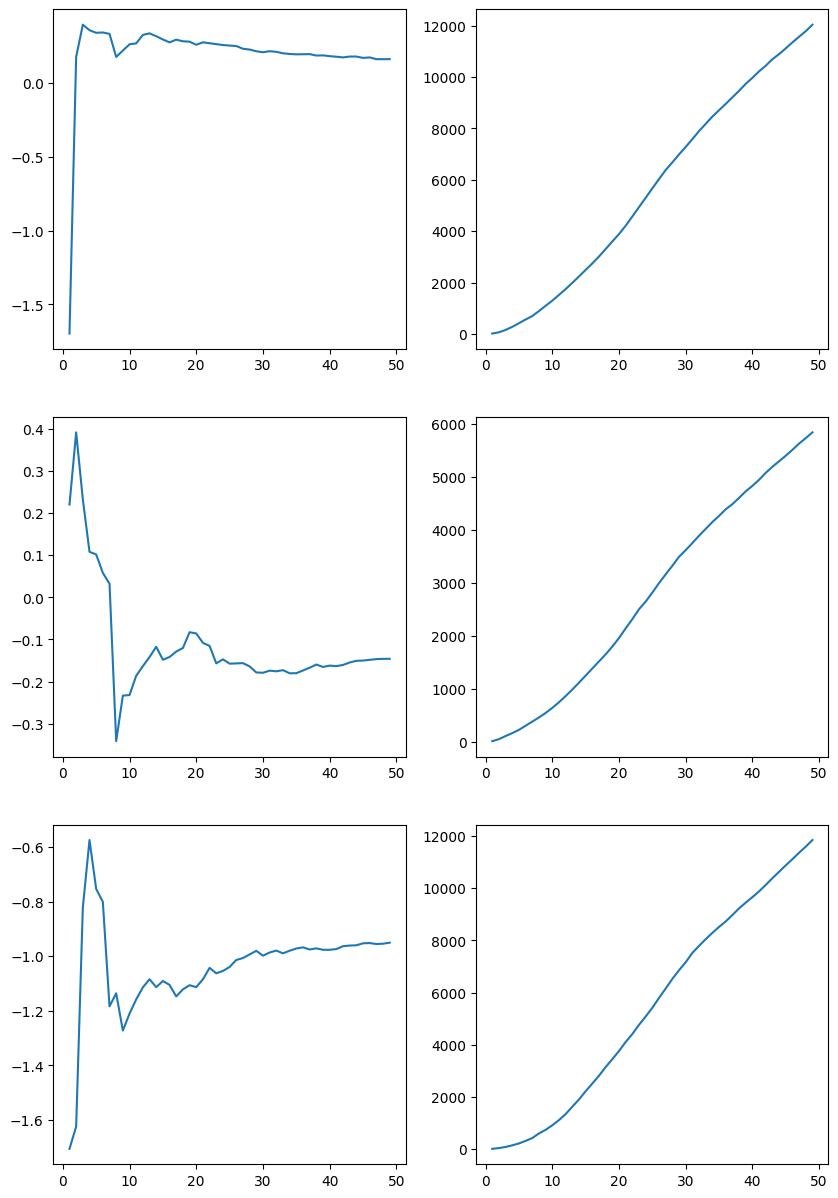

In [50]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [51]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [52]:
close_matches = filter_land_cover(matches[matches.closest_distance < 20])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.59087192].         R squared is : 0.32255467296536533.
The error for coeff = 1 is: 0.09358710524882485.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.31887428].         R squared is : 0.1413826371657525.
The error for coeff = 1 is: -0.2661764172185419.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.07963246].         R squared is : 0.029036413797416283.
The error for coeff = 1 is: -1.1377220683097615.


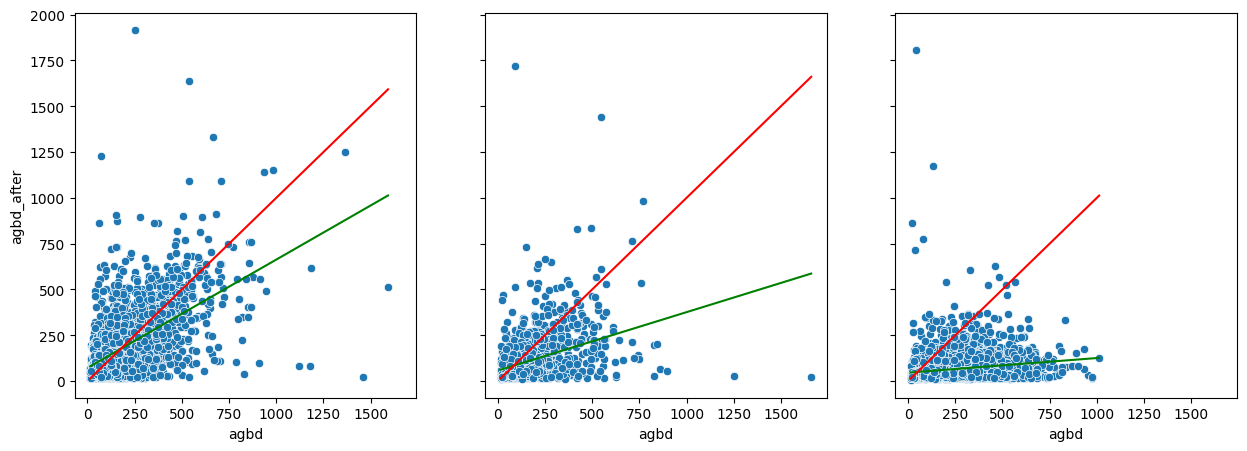

In [53]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

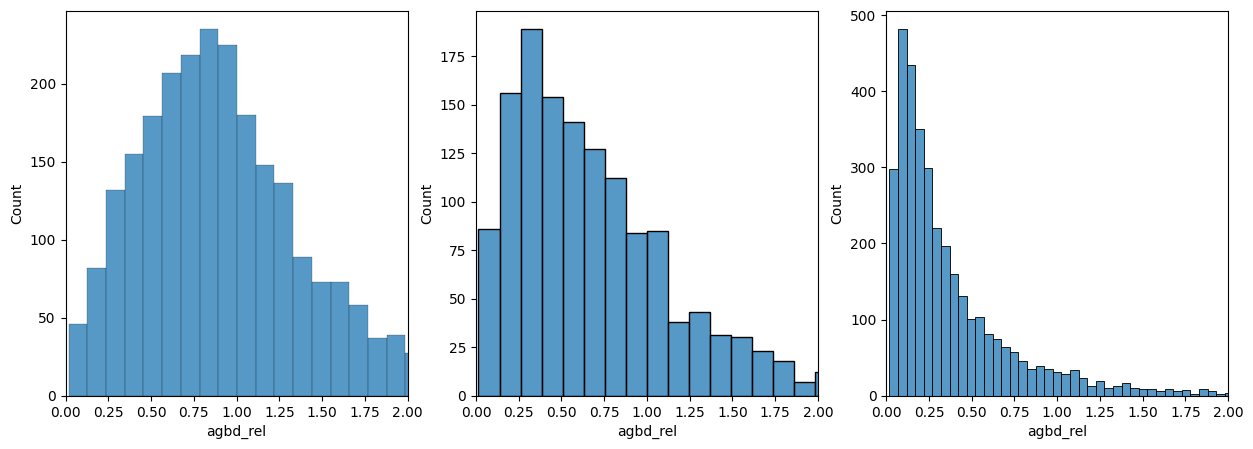

In [54]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]


         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         0.000015  4843.484345 -49787.722178     inf      0.104327   
beta            0.000015  4768.798999 -49757.063038     inf      0.104359   
norm            0.000015  4765.534841 -49772.540357     inf      0.104287   
gamma           0.000021          inf -48922.730561     inf      0.142993   
burr            0.000112  2021.353144 -44484.956535     inf      0.730536   

            ks_pvalue  
lognorm  2.544843e-25  
beta     2.457100e-25  
norm     2.659334e-25  
gamma    2.797955e-47  
burr     0.000000e+00  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 29.97it/s]


{'norm': {'loc': 12.092931238616385, 'scale': 151.11416102773984}}


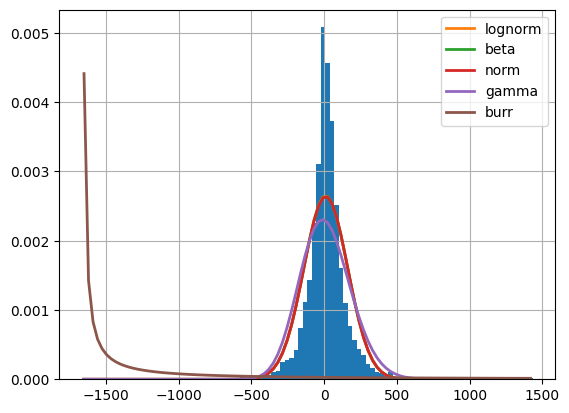

In [55]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


         sumsquare_error          aic           bic  kl_div  ks_statistic  \
gamma           0.000014          inf -26385.056628     inf      0.114511   
beta            0.000018  5191.059703 -26022.055189     inf      0.118536   
norm            0.000018  5155.101744 -26030.821537     inf      0.118194   
lognorm         0.000106  2068.291993 -23492.711340     inf      0.807322   
burr            0.000112  2013.868086 -23407.549634     inf      0.682865   

            ks_pvalue  
gamma    8.174928e-17  
beta     5.464248e-18  
norm     6.904412e-18  
lognorm  0.000000e+00  
burr     0.000000e+00  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 29.79it/s]


{'norm': {'loc': 61.93610529726444, 'scale': 149.85428037473753}}


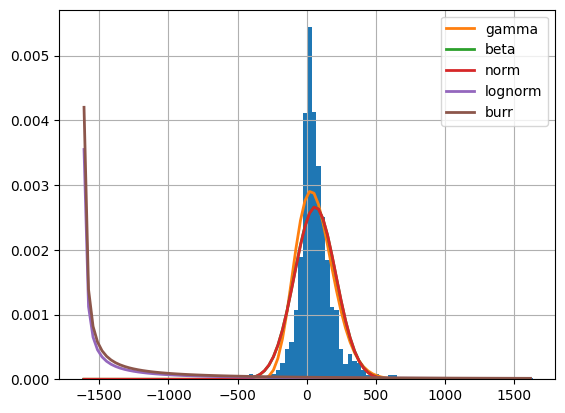

In [56]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  8.38it/s]


         sumsquare_error          aic           bic  kl_div  ks_statistic  \
gamma           0.000007  5676.568477 -71187.712974     inf      0.079541   
beta            0.000007  4993.516249 -71037.389512     inf      0.077320   
norm            0.000007  4862.027328 -71008.809986     inf      0.077455   
lognorm         0.000097  2032.882579 -61826.369870     inf      0.815494   
burr            0.000109  1987.543343 -61413.098045     inf      0.750782   

            ks_pvalue  
gamma    5.397411e-20  
beta     6.462625e-19  
norm     5.572090e-19  
lognorm  0.000000e+00  
burr     0.000000e+00  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s]


{'norm': {'loc': 161.5722930890483, 'scale': 160.107561495062}}


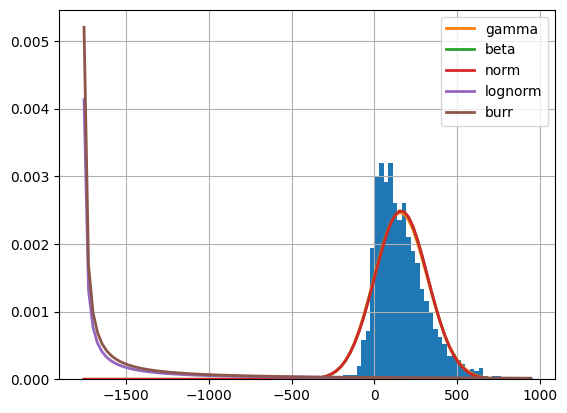

In [57]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

These can't really be done for large samples, so they are probably wrong.

In [58]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8597474694252014, pvalue=1.9478048654114957e-43)
Ttest results: TtestResult(statistic=4.098505898151614, pvalue=4.284495451348027e-05, df=2623)
Wilcoxon test results: WilcoxonResult(statistic=1481426.0, pvalue=5.709251178983156e-10)


In [59]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.81159508228302, pvalue=6.05295299768252e-38)
Ttest results: TtestResult(statistic=15.634880158957994, pvalue=5.425575669291473e-51, df=1431)
Wilcoxon test results: WilcoxonResult(statistic=217076.0, pvalue=9.76932786062644e-80)


In [60]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.9188727140426636, pvalue=4.33404799434094e-40)
Ttest results: TtestResult(statistic=60.135424598277964, pvalue=0.0, df=3551)
Wilcoxon test results: WilcoxonResult(statistic=221480.0, pvalue=0.0)


## PAI Analysis

In [64]:
matches_l2b = gedi_matching.match_across_fire_perimeters(firep, gedi_burned_l2b, 'pai')

Skipped fire NELSON. No matching GEDI shots found.
Skipped fire ATHENS. No matching GEDI shots found.
Skipped fire FLEMING. No matching GEDI shots found.
Skipped fire MELANESE. No matching GEDI shots found.
Skipped fire VALLEY. No matching GEDI shots found.
Skipped fire WALDO. No matching GEDI shots found.
Skipped fire WILLOW. No matching GEDI shots found.
Skipped fire FIELDS. No matching GEDI shots found.
Skipped fire PAVE PAWS. No matching GEDI shots found.
Skipped fire RIOSA. No matching GEDI shots found.
Skipped fire NELSON. No matching GEDI shots found.
Skipped fire TEDDY. No matching GEDI shots found.
Skipped fire AVOCADO. No matching GEDI shots found.
Skipped fire HONCUT. No matching GEDI shots found.
Skipped fire GRAND. No matching GEDI shots found.
Skipped fire CLARK. No matching GEDI shots found.
Skipped fire KARCHNER. No matching GEDI shots found.
Skipped fire GARDEN. No matching GEDI shots found.
Skipped fire FEATHER. No matching GEDI shots found.
Skipped fire FLAT. No matc

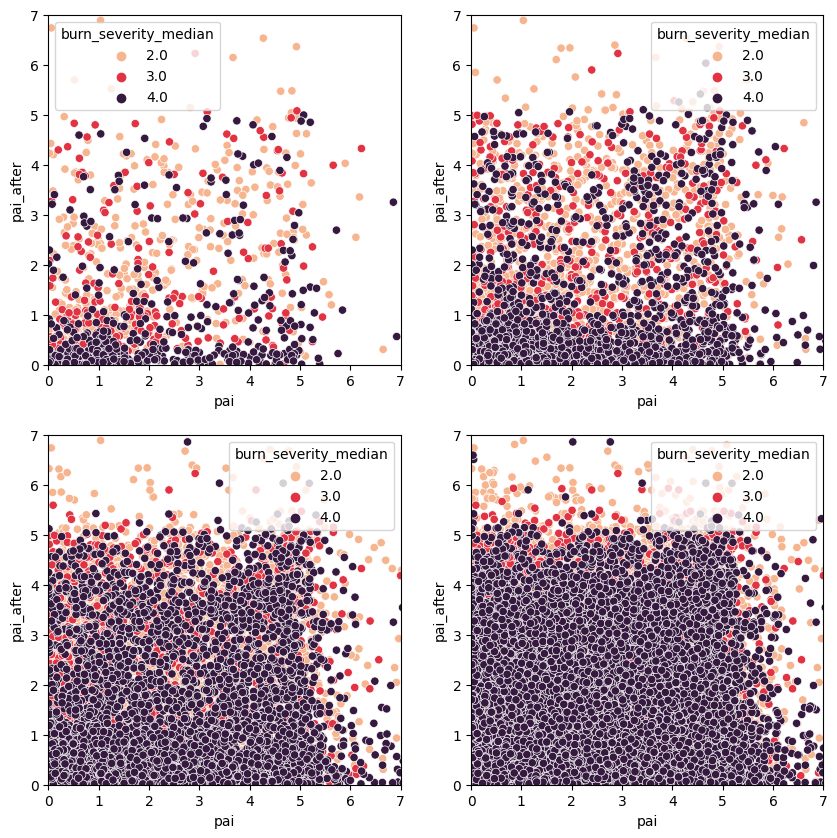

In [66]:
matching_analysis.plot_severity_for_distance(matches_l2b, 'pai', 7)

In [67]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

In [68]:
close_matches = l2b_filter_land_cover(matches_l2b[matches_l2b.closest_distance < 20])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.36949867].         R squared is : 0.16059037564986023.
The error for coeff = 1 is: -0.1226848211549294.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.3045751].         R squared is : 0.1194963930029207.
The error for coeff = 1 is: -0.2578823924096476.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.17713807].         R squared is : 0.0494857873568344.
The error for coeff = 1 is: -0.9788057245141317.


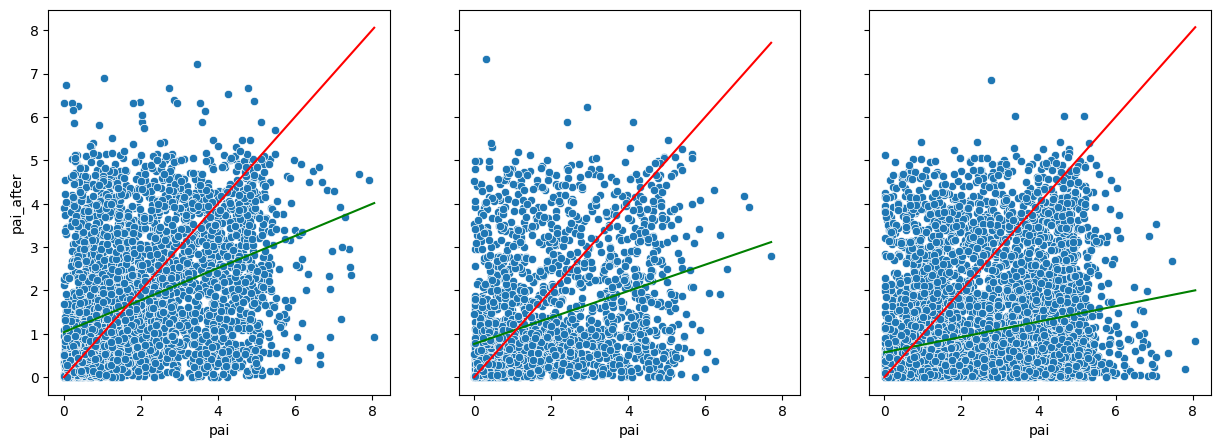

In [70]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'pai')

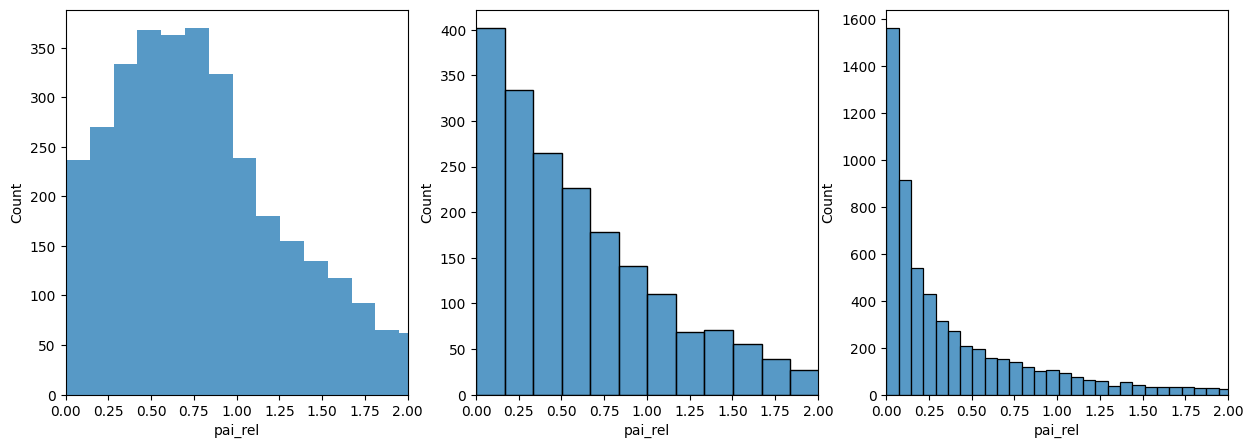

In [71]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


         sumsquare_error         aic           bic  kl_div  ks_statistic  \
burr            0.207397  816.525612 -39642.004762     inf      0.064521   
lognorm         0.318051  881.014078 -37931.871699     inf      0.090851   
gamma           0.319225  878.433427 -37917.071430     inf      0.092048   
beta            0.319262  880.576233 -37908.303920     inf      0.092861   
norm            0.319306  876.635299 -37924.340974     inf      0.093106   

            ks_pvalue  
burr     5.459984e-15  
lognorm  2.568475e-29  
gamma    4.393940e-30  
beta     1.303989e-30  
norm     9.038059e-31  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 27.62it/s]


{'norm': {'loc': 0.16709496112893754, 'scale': 1.641697532269161}}


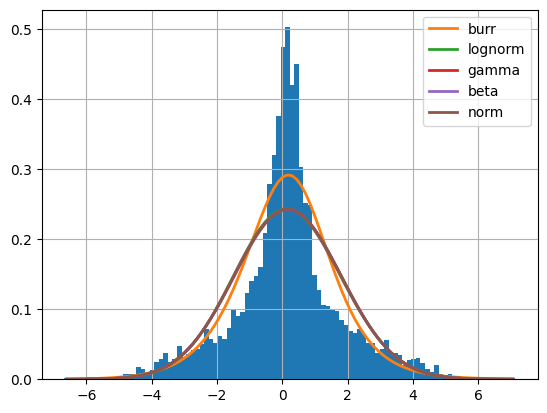

In [72]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


         sumsquare_error         aic           bic  kl_div  ks_statistic  \
burr            0.263389  786.119063 -20941.803181     inf      0.073128   
lognorm         0.364188  843.965611 -20201.020934     inf      0.092913   
gamma           0.365020  840.126360 -20195.745681     inf      0.093065   
beta            0.365685  837.646863 -20183.796743     inf      0.092242   
norm            0.366035  831.622762 -20197.078296     inf      0.091885   

            ks_pvalue  
burr     3.453675e-11  
lognorm  8.341610e-18  
gamma    7.313146e-18  
beta     1.484005e-17  
norm     2.013422e-17  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 30.16it/s]


{'norm': {'loc': 0.46449134285570565, 'scale': 1.6660176591212055}}


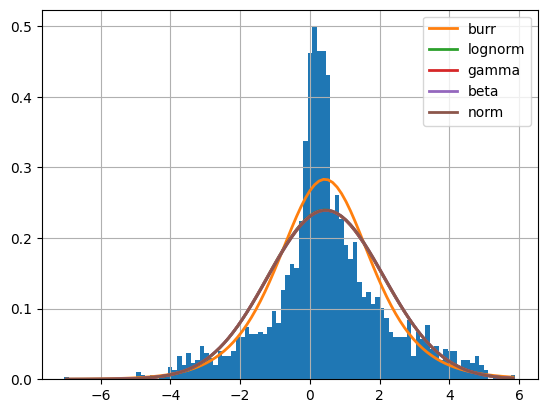

In [74]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


         sumsquare_error         aic           bic  kl_div  ks_statistic  \
burr            0.070902  703.749511 -72731.601042     inf      0.036121   
lognorm         0.090267  735.101589 -71200.052134     inf      0.056592   
gamma           0.094199  732.101466 -70928.058119     inf      0.053077   
norm            0.095947  730.428645 -70819.550160     inf      0.052172   
beta            0.102496  734.062204 -70380.834439     inf      0.052158   

            ks_pvalue  
burr     1.146671e-07  
lognorm  3.370838e-18  
gamma    4.648378e-16  
norm     1.570239e-15  
beta     1.598565e-15  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]

{'norm': {'loc': 1.3098718060335413, 'scale': 1.77239627517666}}


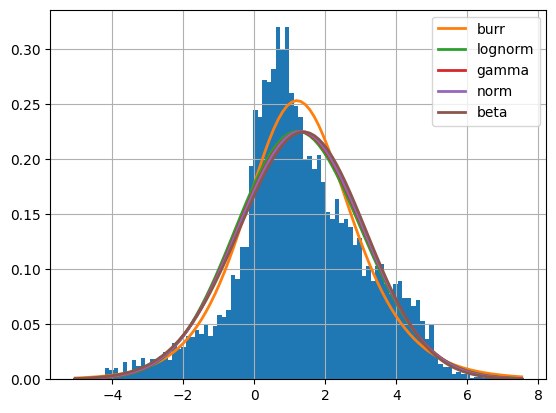

In [73]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'pai')

## PAI Z Analysis

In [95]:
importlib.reload(gedi_matching)

<module 'src.processing.recent_fires.gedi_matching' from '/home/jk871/fire-regen/src/processing/recent_fires/gedi_matching.py'>

In [96]:
matches_paiz = gedi_matching.match_pai_z_across_fire_perimeters(firep, gedi_burned_l2b)

Skipped fire NELSON. No matching GEDI shots found.
Skipped fire ATHENS. No matching GEDI shots found.
Skipped fire FLEMING. No matching GEDI shots found.
Skipped fire MELANESE. No matching GEDI shots found.
Skipped fire VALLEY. No matching GEDI shots found.
Skipped fire WALDO. No matching GEDI shots found.
Skipped fire WILLOW. No matching GEDI shots found.
Skipped fire FIELDS. No matching GEDI shots found.
Skipped fire PAVE PAWS. No matching GEDI shots found.
Skipped fire RIOSA. No matching GEDI shots found.
Skipped fire NELSON. No matching GEDI shots found.
Skipped fire TEDDY. No matching GEDI shots found.
Skipped fire AVOCADO. No matching GEDI shots found.
Skipped fire HONCUT. No matching GEDI shots found.
Skipped fire GRAND. No matching GEDI shots found.
Skipped fire CLARK. No matching GEDI shots found.
Skipped fire KARCHNER. No matching GEDI shots found.
Skipped fire GARDEN. No matching GEDI shots found.
Skipped fire FEATHER. No matching GEDI shots found.
Skipped fire FLAT. No matc

In [97]:
close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 20])

In [98]:
unpacked = matching_analysis.transform_pai_z_data(close_matches)

(0.0, 13.0)

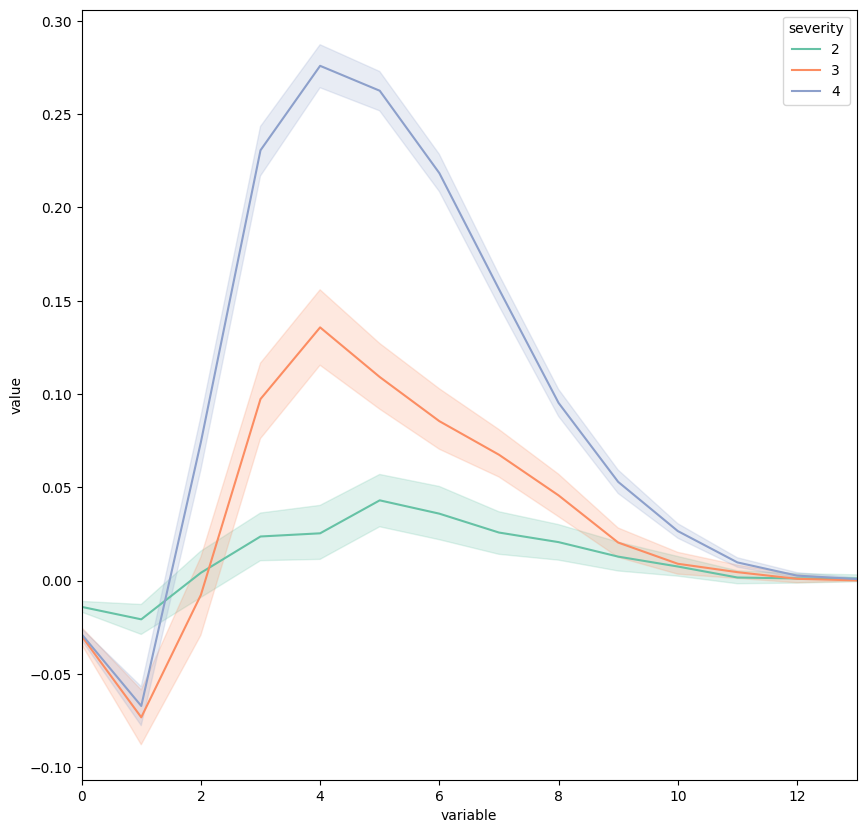

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(unpacked, x='variable', y='value', hue='severity', ax=ax, palette='Set2')
ax.set_xlim((0, 13))

(0.0, 13.0)

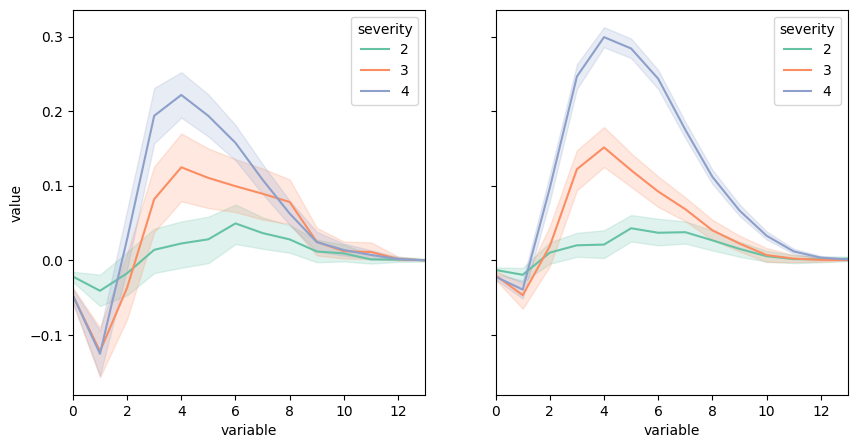

In [116]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.lineplot(unpacked[unpacked.date_since < 6], x='variable', y='value', hue='severity', ax=ax[0], palette='Set2')
sns.lineplot(unpacked[unpacked.date_since > 12], x='variable', y='value', hue='severity', ax=ax[1], palette='Set2')
ax[0].set_xlim((0, 13))

(0.0, 13.0)

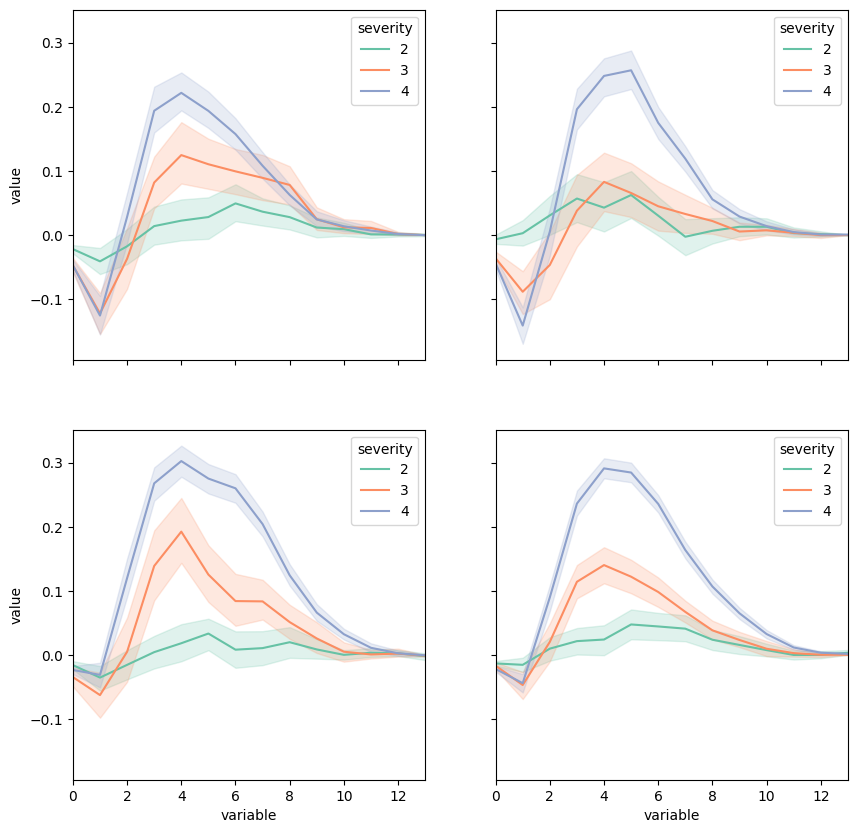

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
sns.lineplot(unpacked[unpacked.date_since < 6], x='variable', y='value', hue='severity', ax=ax[0][0], palette='Set2')
sns.lineplot(unpacked[unpacked.date_since.isin(range(6, 12))], x='variable', y='value', hue='severity', ax=ax[0][1], palette='Set2')
sns.lineplot(unpacked[unpacked.date_since.isin(range(12, 18))], x='variable', y='value', hue='severity', ax=ax[1][0], palette='Set2')
sns.lineplot(unpacked[unpacked.date_since.isin(range(18, 24))], x='variable', y='value', hue='severity', ax=ax[1][1], palette='Set2')
ax[0][0].set_xlim((0, 13))

(0.0, 13.0)

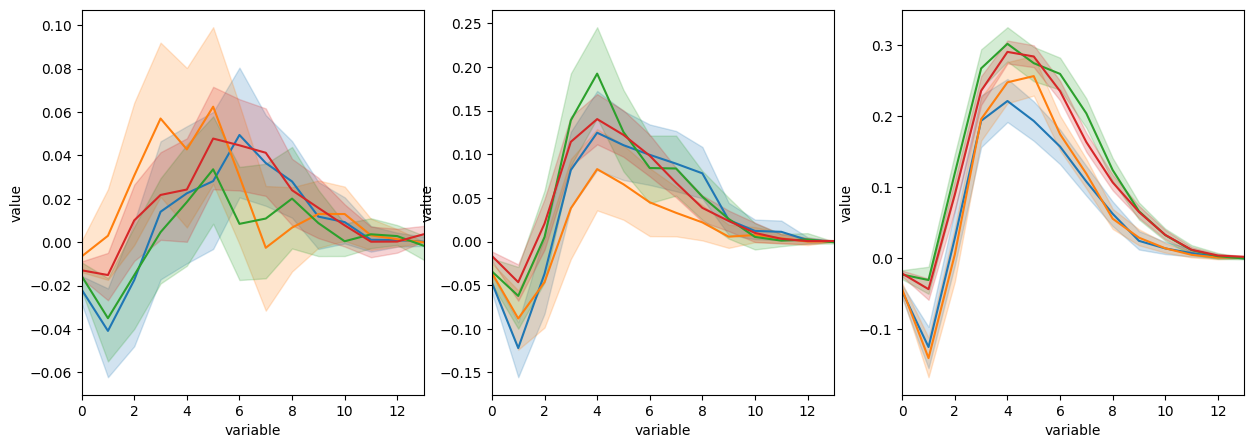

In [114]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
idx = 0
for severity in [2, 3, 4]:
    to_plot = unpacked[unpacked.severity == severity]
    sns.lineplot(to_plot[to_plot.date_since < 6], x='variable', y='value', ax=ax[idx])
    sns.lineplot(to_plot[to_plot.date_since.isin(range(6, 12))], x='variable', y='value', ax=ax[idx])
    sns.lineplot(to_plot[to_plot.date_since.isin(range(12, 18))], x='variable', y='value', ax=ax[idx])
    sns.lineplot(to_plot[to_plot.date_since.isin(range(18, 24))], x='variable', y='value', ax=ax[idx])
    idx += 1
ax[0].set_xlim((0, 13))

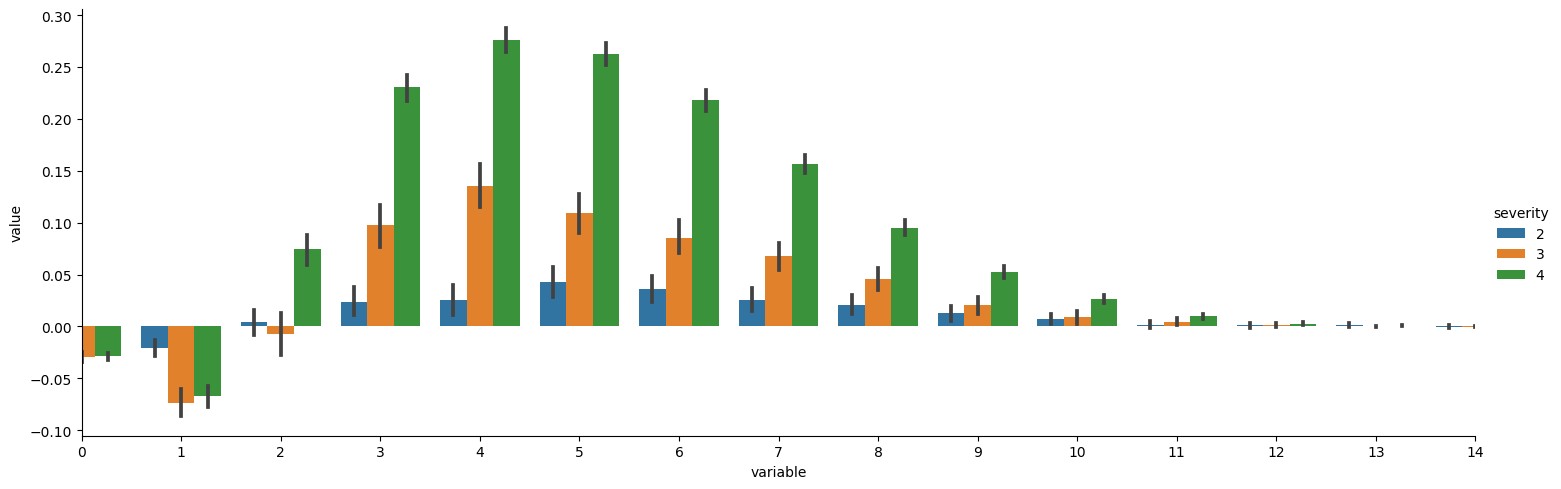

In [118]:
g = sns.catplot(unpacked, x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))

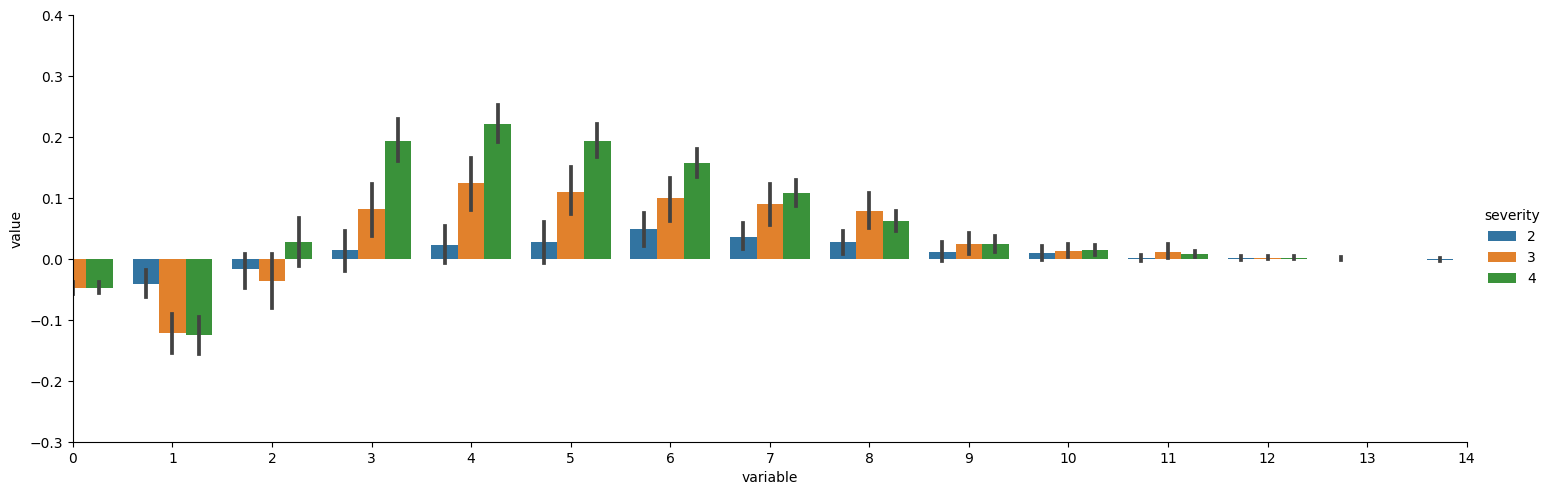

In [119]:
g = sns.catplot(unpacked[unpacked.date_since < 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

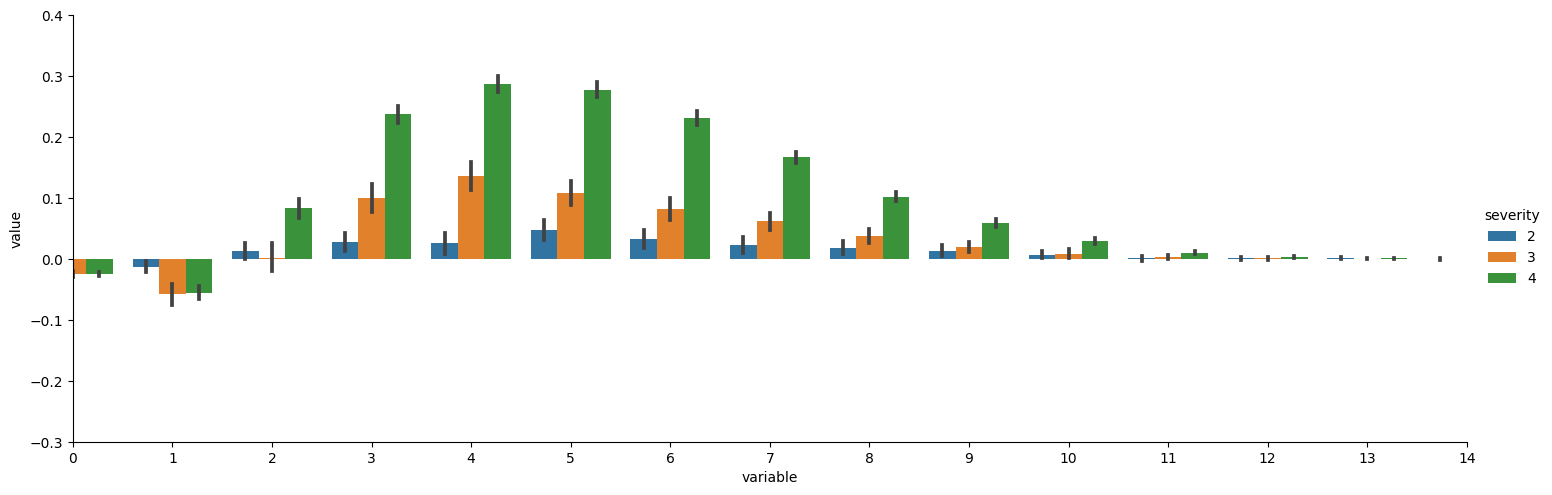

In [120]:
g = sns.catplot(unpacked[unpacked.date_since > 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

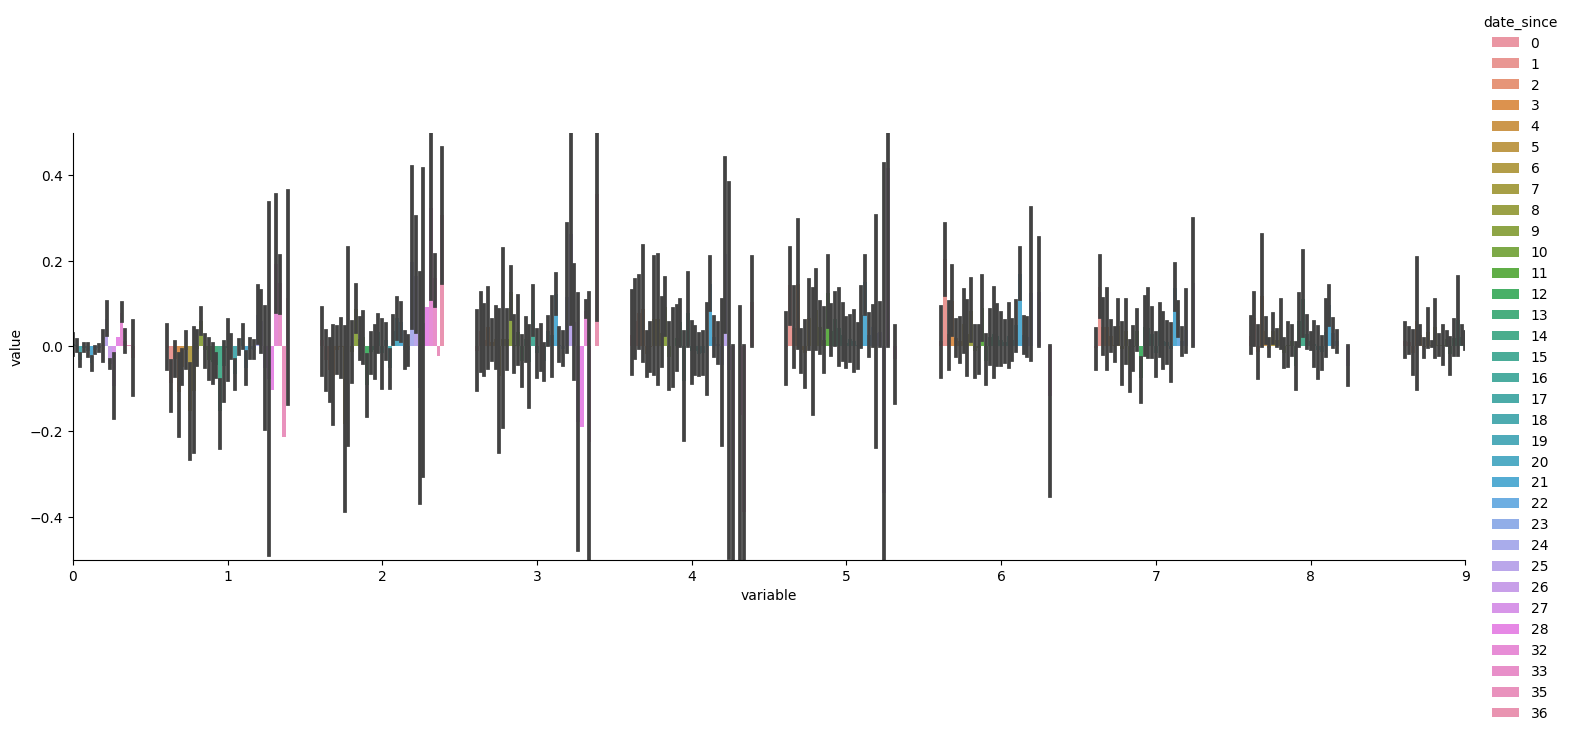

In [121]:
g = sns.catplot(unpacked[unpacked.severity==2], x='variable', y='value', hue='date_since', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-0.5,0.5))

In [122]:
unpacked_granular = gedi_matching.add_date_since_burn_categories_granular(unpacked.reset_index())
unpacked_coarse = gedi_matching.add_date_since_burn_categories_coarse(unpacked.reset_index())

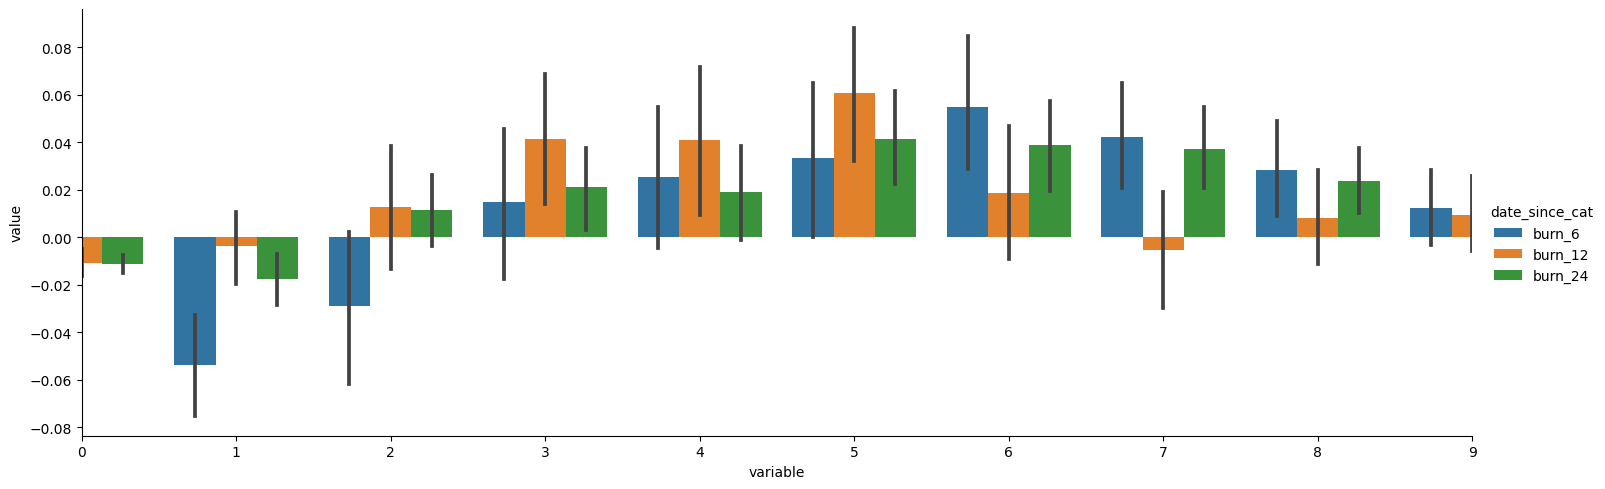

In [125]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==2], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))

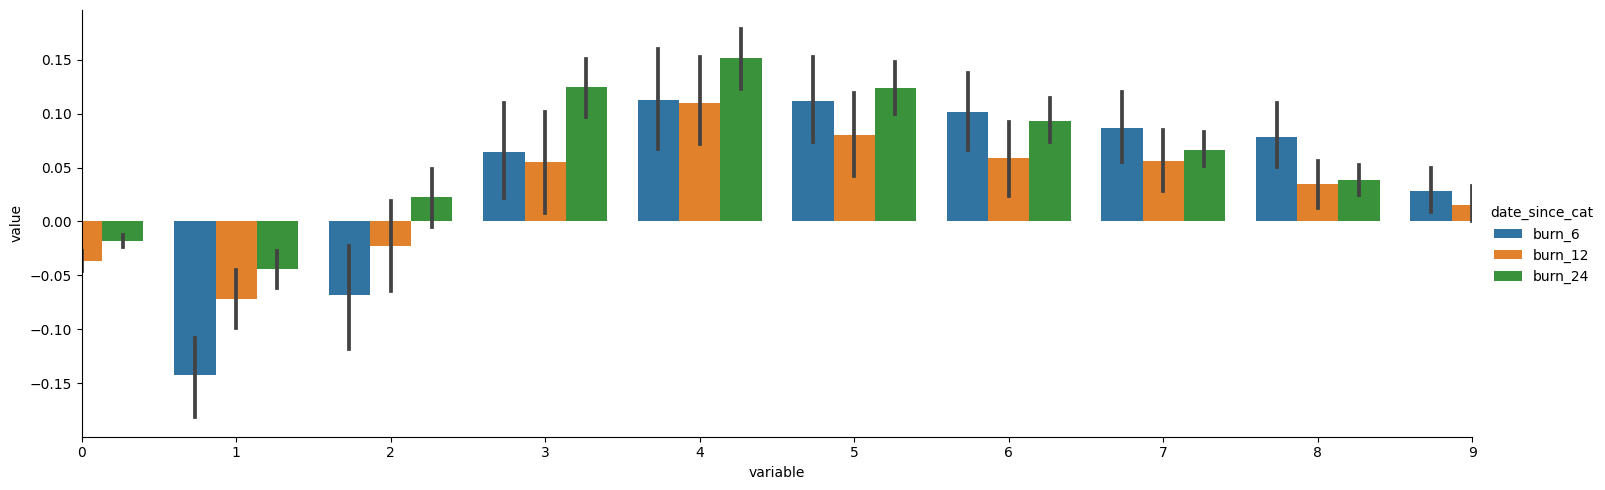

In [128]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==3], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))

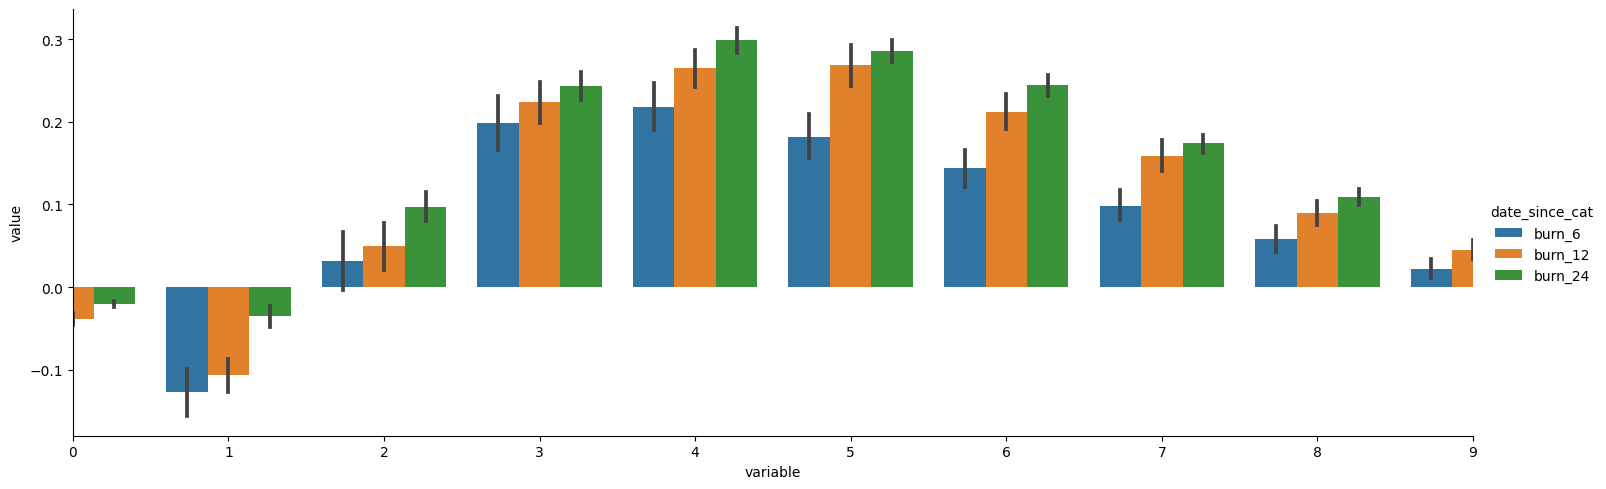

In [126]:
g = sns.catplot(unpacked_coarse[unpacked_coarse.severity==4], x='variable', y='value', hue='date_since_cat', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))

<Axes: xlabel='date_since_cat', ylabel='value'>

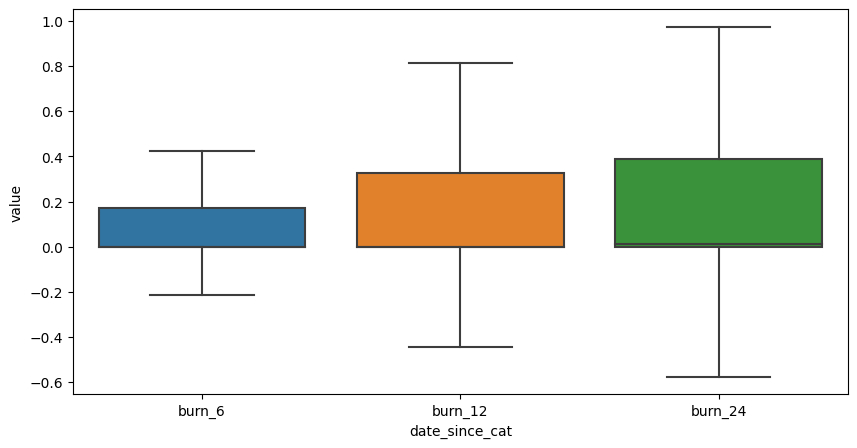

In [135]:
plt.figure(figsize=(10,5))
lala = unpacked_coarse[(unpacked_coarse.severity==4) & (unpacked_coarse.variable == 6)]
sns.boxplot(lala, x='date_since_cat', y='value', showfliers=False)